In [46]:
# Importing Base Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [47]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

# DATA PREPROCESSING

## DATA CLEANING PIPLINE

In [100]:
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def data_cleaning_pipline(data, is_test_data=False):
    # General step
    clean_step_1 = data.drop(['id', 'clean_title'], axis=1)

    if not is_test_data:
        print("TRAIN DATA CLEANING PIPLINE...")
        num_columns = clean_step_1.select_dtypes(include=np.number).columns
        cat_columns = clean_step_1.select_dtypes(exclude=np.number).columns
        imputer = ColumnTransformer([
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_columns),
            ('num_imputer', SimpleImputer(strategy='median'), num_columns)
        ], remainder='drop')
        clean_step_2 = pd.DataFrame(imputer.fit_transform(clean_step_1), columns=[*cat_columns, *num_columns])
        # Ensure numerical columns are converted back to their original types
        clean_step_2[num_columns] = clean_step_2[num_columns].apply(pd.to_numeric, errors='coerce')

        print("Missing Values Imputed...")

        # Detecting And Removing Outliers From Data
        outliers = pd.DataFrame() # An empty dataframe
        for feature in num_columns:
            q1, q3 = clean_step_2[feature].quantile(0.25), clean_step_2[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers_instances = clean_step_2[(clean_step_2[feature] < lower_bound) | (clean_step_2[feature] > upper_bound)]
            outliers = pd.concat([outliers, outliers_instances]).drop_duplicates()
            print(f"FEATURE: {feature}, NUM OF OUTLIERS: {len(outliers_instances)}")
        clean_step_2 = clean_step_2.drop(outliers.index)
        print(f"TOTAL OUTLIERS REMOVED: {len(outliers)}")

        iso_forest = IsolationForest(contamination=0.19, random_state=42)
        predictions = iso_forest.fit_predict(clean_step_2[num_columns])
        # Outliers are marked as -1
        outliers = clean_step_2[predictions == -1]
        clean_step_2 = clean_step_2.drop(outliers.index)

        # Removing weird symbols from the dataset
        clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]
        print("Removed Weird Symbols")

        return clean_train

    if is_test_data:
        print("TEST DATA CLEANING PIPLINE...")
        num_columns = clean_step_1.select_dtypes(include=np.number).columns
        cat_columns = clean_step_1.select_dtypes(exclude=np.number).columns
        imputer = ColumnTransformer([
            ('cat_imputer', SimpleImputer(strategy='most_frequent'), cat_columns),
            ('num_imputer', SimpleImputer(strategy='median'), num_columns)
        ], remainder='drop')
        clean_step_2 = pd.DataFrame(imputer.fit_transform(clean_step_1), columns=[*cat_columns, *num_columns])
        # Ensure numerical columns are converted back to their original types
        clean_step_2[num_columns] = clean_step_2[num_columns].apply(pd.to_numeric, errors='coerce')
        print("Missing Values Imputed...")

        # Removing weird symbols from the dataset
        clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]
        print("Removed Weird Symbols")

        return clean_train


cleaned_train = data_cleaning_pipline(train, is_test_data=False)
cleaned_test = data_cleaning_pipline(test, is_test_data=True)

TRAIN DATA CLEANING PIPLINE...
Missing Values Imputed...
FEATURE: model_year, NUM OF OUTLIERS: 5132
FEATURE: milage, NUM OF OUTLIERS: 1766
FEATURE: price, NUM OF OUTLIERS: 10880
TOTAL OUTLIERS REMOVED: 17326


C:\Users\deusm\AppData\Local\Temp\ipykernel_10432\2600172909.py:43: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]


Removed Weird Symbols
TEST DATA CLEANING PIPLINE...
Missing Values Imputed...


C:\Users\deusm\AppData\Local\Temp\ipykernel_10432\2600172909.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_train = clean_step_2[~clean_step_2.applymap(lambda x: isinstance(x, str) and bool(pd.Series(x).str.contains(r'[^\x00-\x7F]').any())).any(axis=1)]


Removed Weird Symbols


## IDENTIFYING HIGH CARDINALITY CATEGORICAL VARIABLES

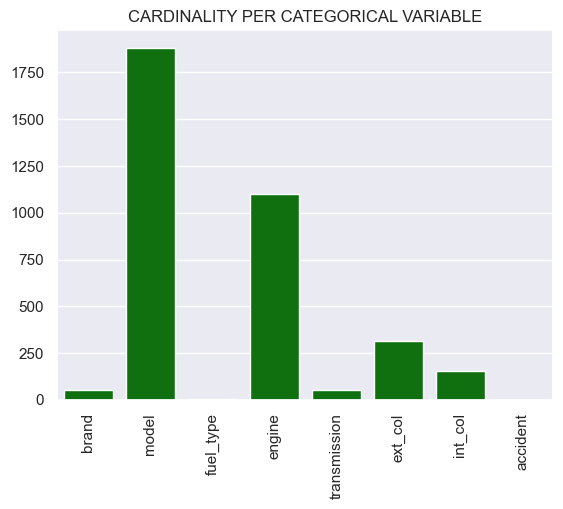

In [102]:
# Cardinality- Number of unique data per feature or categorical variable
sns.barplot(cleaned_train.select_dtypes(exclude=np.number).nunique(), color='green')
plt.xticks(rotation=90)
plt.title('CARDINALITY PER CATEGORICAL VARIABLE')
plt.show()

In [111]:
cleaned_train['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel     2966
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel     2596
2.0L I4 16V GDI DOHC Turbo                       2277
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel     2237
340.0HP 3.0L V6 Cylinder Engine Gasoline Fuel    2223
                                                 ... 
290.0HP 7.4L 8 Cylinder Engine Gasoline Fuel        1
3.2L H6 24V MPFI DOHC                               1
70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel         1
150.0HP 2.7L 4 Cylinder Engine Gasoline Fuel        1
443.0HP 4.4L 8 Cylinder Engine Gasoline Fuel        1
Name: count, Length: 1102, dtype: int64

In [112]:
cleaned_test['engine'].value_counts()

engine
355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel            2179
240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel            1928
420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel            1847
2.0L I4 16V GDI DOHC Turbo                              1795
375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel           1572
                                                        ... 
111.2Ah / FR 70kW / RR 160kW (697V)                        1
3.2L V6 18V MPFI SOHC                                      1
266.0HP 2.5L 4 Cylinder Engine Plug-In Electric/Gas        1
275.0HP 3.5L V6 Cylinder Engine Flex Fuel Capability       1
226.0HP 1.6L 4 Cylinder Engine Gas/Electric Hybrid         1
Name: count, Length: 1116, dtype: int64

In [117]:
# COMBINING LESS FREQUENT CATEGORIES TOGETHER
def combiner(train_data, test_data, categorical_features, threshold, stats=None, drop_original=None):
    """A function that combines less frequent features
    whose normalized frequency is less than the threshold
    in categorical variables"""
    for feature in categorical_features:
        print(">> " + feature.upper())
        print(f'train_CARDINALITY BEFORE: {train_data[feature].nunique()}')
        print(f'test_CARDINALITY BEFORE: {test_data[feature].nunique()}')
        cat_freq = train_data[feature].value_counts(normalize=True)
        cat_to_keep = cat_freq[cat_freq >= threshold].index
        train_data[feature + '_group'] = train_data[feature].where(train_data[feature].isin(cat_to_keep), 'Other')
        test_data[feature + '_group'] = test_data[feature].where(test_data[feature].isin(cat_to_keep), 'Other')
        print(f'train_CARDINALITY AFTER: {train_data[feature + "_group"].nunique()}')
        print(f'train_CARDINALITY AFTER: {test_data[feature + "_group"].nunique()}')
        if stats:
            print('\n\n')
            print(cat_freq)
        if drop_original:
            train_data = train_data.drop([feature], axis=1)
            test_data = test_data.drop([feature], axis=1)
    return train_data, test_data

In [118]:
cleaned_train1, cleaned_test1 = combiner(train_data=cleaned_train, test_data=cleaned_test, categorical_features=cleaned_train.select_dtypes(exclude=np.number).columns, threshold=0.01, drop_original=True)

>> BRAND
train_CARDINALITY BEFORE: 55
test_CARDINALITY BEFORE: 55
train_CARDINALITY AFTER: 25
train_CARDINALITY AFTER: 25
>> MODEL
train_CARDINALITY BEFORE: 1881
test_CARDINALITY BEFORE: 1888
train_CARDINALITY AFTER: 3
train_CARDINALITY AFTER: 3
>> FUEL_TYPE
train_CARDINALITY BEFORE: 6
test_CARDINALITY BEFORE: 6
train_CARDINALITY AFTER: 5
train_CARDINALITY AFTER: 5
>> ENGINE
train_CARDINALITY BEFORE: 1102
test_CARDINALITY BEFORE: 1116
train_CARDINALITY AFTER: 15
train_CARDINALITY AFTER: 15
>> TRANSMISSION
train_CARDINALITY BEFORE: 51
test_CARDINALITY BEFORE: 51
train_CARDINALITY AFTER: 16
train_CARDINALITY AFTER: 16
>> EXT_COL
train_CARDINALITY BEFORE: 316
test_CARDINALITY BEFORE: 316
train_CARDINALITY AFTER: 7
train_CARDINALITY AFTER: 7
>> INT_COL
train_CARDINALITY BEFORE: 155
test_CARDINALITY BEFORE: 155
train_CARDINALITY AFTER: 9
train_CARDINALITY AFTER: 9
>> ACCIDENT
train_CARDINALITY BEFORE: 2
test_CARDINALITY BEFORE: 2
train_CARDINALITY AFTER: 2
train_CARDINALITY AFTER: 2
>> BRAN

In [134]:
cleaned_train

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,model_year,milage,price,brand_group
3,Genesis,G90 5.0 Ultimate,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,2017.0,19500.0,45000.0,Other
6,Audi,A8 L 3.0T,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,2016.0,62200.0,28500.0,Audi
7,Chevrolet,Silverado 1500 1LZ,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,2016.0,102604.0,12500.0,Chevrolet
8,Ford,F-150 XLT,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,2020.0,38352.0,62890.0,Ford
9,BMW,M4 Base,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,2015.0,74850.0,4000.0,BMW
...,...,...,...,...,...,...,...,...,...,...,...,...
188528,Cadillac,Escalade ESV Platinum,Gasoline,420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,Beige,None reported,2017.0,49000.0,27500.0,Cadillac
188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,Gasoline,385.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,White,Black,At least 1 accident or damage reported,2018.0,28600.0,30000.0,Mercedes-Benz
188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,Gasoline,469.0HP 4.0L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,White,Black,None reported,2021.0,13650.0,86900.0,Mercedes-Benz
188531,Audi,S5 3.0T Prestige,Gasoline,3.0L,1-Speed Automatic,Daytona Gray Pearl Effect,Black,None reported,2022.0,13895.0,84900.0,Audi


# DATA TRANSFORMATION PIPELINE

In [119]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# # Convert model_year To String
# train['model_year'] = train['model_year'].astype(str)


num_features = ['model_year', 'milage']

transformer = ColumnTransformer([
    ('cat', OneHotEncoder(sparse_output=False), cleaned_train1.select_dtypes(exclude=np.number).columns),
    ('num', StandardScaler(), num_features)
], remainder='drop')


In [120]:
# TRANSFORMING THE WHOLE DATASET
transformed_train = transformer.fit_transform(cleaned_train1)
transformed_test = transformer.fit_transform(cleaned_test1)

In [121]:
transformed_train[0:5, :]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [122]:
transformed_test[0:5, :]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

## X, y

In [135]:
X_train, y_train  = transformed_train, cleaned_train['price'].values

In [136]:
y_train

array([45000., 28500., 12500., ..., 86900., 84900., 28995.])

# Model_1, XGBoost

In [137]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

xgb = XGBRegressor()

mse_scorer = make_scorer(mean_squared_error, greater_is_better=True)

scores = cross_val_score(xgb, X_train, y_train,
                         scoring=mse_scorer,
                         cv=4, n_jobs=-1)

In [138]:
print(np.sqrt(scores))

[10568.0809956  10550.92029073 10631.55879316 10569.77995907]


In [139]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [140]:
pred = xgb_model.predict(transformed_test)

In [141]:
pred

array([19974.74 , 47384.83 , 44596.11 , ..., 19352.87 , 16568.836,
       33668.58 ], dtype=float32)